<a href="https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn?scriptVersionId=125038852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [1]:
#  ! pip install imutils -q

import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

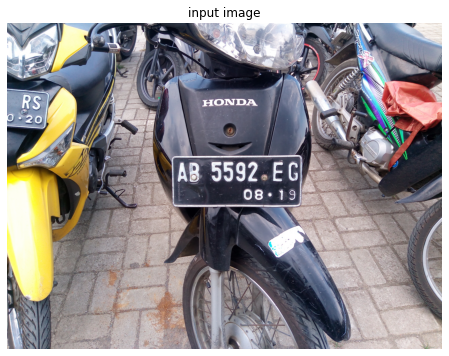

In [42]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    

# req = urllib.request.urlopen('https://awsimages.detik.net.id/customthumb/2011/05/09/648/plat-nomor-dalam.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB2638XU.jpg')
req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB5592EG.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AD2914JG.jpg')


arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'    

# img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
display(img, 'input image')

# program untuk mendeteksi posisi plat nomor dari motor


detected plat no: 1
1092


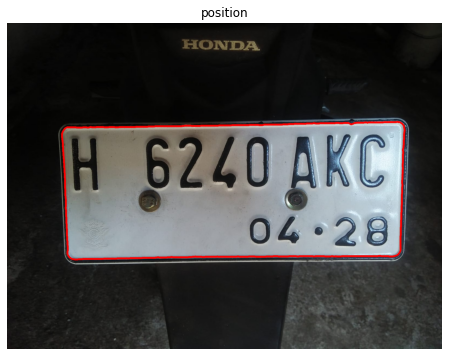

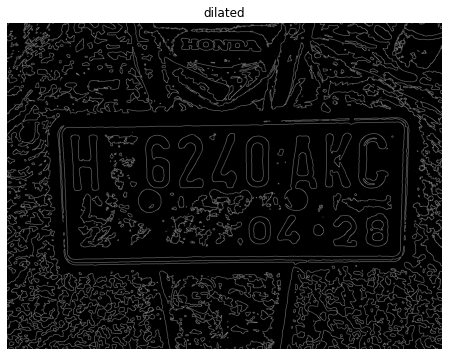

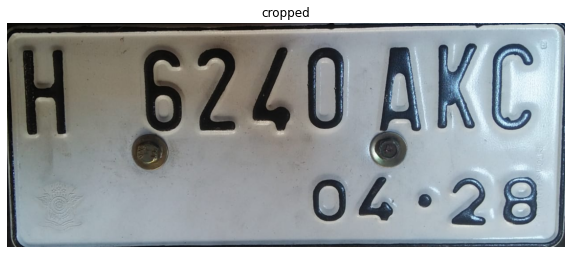

In [49]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H4517TI2.jpg')
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# req = urllib.request.urlopen('https://t-2.tstatic.net/gorontalo/foto/bank/images/12102022_plat-nomor-putih.jpg')

# req = urllib.request.urlopen('https://image.cermati.com/q_70,w_1200,h_800,c_fit/cgbt1mggrzxkk5p5xtot')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'    

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (19,19), 0) 
hisimg  = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
edged   = cv2.Canny(hisimg, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)

platno=[]
index=0
sx = sy = sw = sh =[]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
#     print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
    if w > 500 and h>200 and aspect_ratio <= 4 : 
        platno.append(index)
        sx.append(x)
        sy.append(y)
        sh.append(w)
        sw.append(h)
    index += 1
print(f'detected plat no: {len(platno)}')

if len(platno) == 1 or len(platno)>=1:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    cv2.drawContours(detectedimg, contours, indexplatno, (0, 0, 255), 5)
    croppedimg = img[y: y+h, x:x+w]

print(indexplatno)

# display(hisimg, "contour")
# display(edged, "edged")
display(detectedimg, "position")
display(dilate, "dilated")
display(croppedimg, "cropped")



# program untuk mendeteksi digit dari plat nomor motor

x: 676, y: 51, w: 87, h: 190
x: 818, y: 50, w: 121, h: 277
x: 306, y: 48, w: 91, h: 196
x: 31, y: 47, w: 106, h: 207
x: 427, y: 45, w: 94, h: 199
x: 1089, y: 42, w: 112, h: 203
x: 967, y: 40, w: 99, h: 203
x: 551, y: 39, w: 92, h: 205
detected candidate plat no: 8
[76, 77]


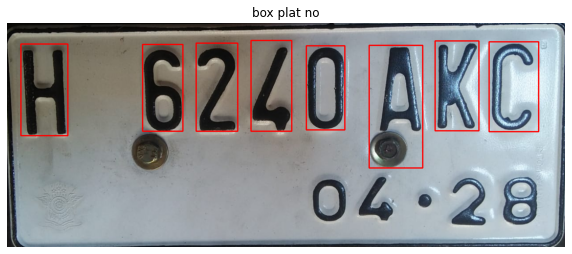

[81, 79, 82, 86, 76, 77, 85, 83]


In [50]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC1.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6498SI.jpg')

# req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/a/a5/Plat_Nomor_Nganjuk_%283_Huruf%29.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1)

# img = cv2.pyrDown(img)
grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (21,21), 0) 
hisimg  = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
edged   = cv2.Canny(hisimg, 10, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
image_copy = croppedimg.copy()
imgrec = croppedimg.copy()

platno=[]
index=0
realPlatno=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    luas = w*h
#     print(f'aspect ratio from index: {index}, aspectRatio: {aspect_ratio}, w: {w}, h: {h}')
    if w > 42 and h>=70 and h <300 and aspect_ratio <= 0.7 and y<150: 
        platno.append(index)
        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)
        realPlatno+=1
    index += 1
print(f'detected candidate plat no: {len(platno)}')

for a in platno:
    xa,ya,wa,ha = cv2.boundingRect(contour[a])
#     print("=========================")
    for b in platno:
        if a == b:
            continue
        else:
            xb,yb,wb,hb = cv2.boundingRect(contour[b])
            ydif = ya-yb
            xdif = xa-xb
            wdif = wa-wb
            hdif = ha-hb
#             print(f'ydif: {ydif}, xdif: {xdif}, wdif: {wdif}, hdif: {hdif}')
            
counter=0
score=np.zeros(len(platno))
for a in platno:
    xa, ya, wa, ha = cv2.boundingRect(contours[a])
#     print("============================")
    for b in platno:
        if a == b :
            continue
        else:
            xb, yb, wb, hb = cv2.boundingRect(contours[b])
            ydif = ya-yb
#             print(f'ya: {ya}, yb: {yb}, ydif: {ydif}')
            
            if ydif<11:
                score[counter] = score[counter]+1
            
    counter += 1

indexRealChar=[]
charCounter=0
for sc in score:
    if sc != max(score):
        indexRealChar.append(platno[charCounter])
        
    charCounter+=1
    
print(indexRealChar)
finalimg = croppedimg.copy()
for char in indexRealChar:
    x,y,w,h = cv2.boundingRect(contours[char])
    cv2.rectangle(finalimg, (x,y), (x+w,y+h), (150,0,0),2)
    
display(imgrec, "box plat no")
# display(finalimg, "final hopefully")
# display(hisimg, "detected plat no")
# display(blured, "detected plat no")
# display(image_copy, "contour")
# display(edged, "edged")
# display(dilate, "dilated")
urutx = []
for char in platno:
    x,y,w,h = cv2.boundingRect(contours[char])
    urutx.append(x)
urutx = sorted(urutx)

## urutkan karakter plat nomor dari kiri ke kanan
cropCharUrut=[]
for ux in urutx:
    for char in platno :
        x,y,w,h = cv2.boundingRect(contours[char])
        if x == ux: 
            cropCharUrut.append(char)
            break
    

print(cropCharUrut)


# **Selanjutnya buat program untuk ekstract setiap digit dari plat nomor dan melakukan klasifikasi karakter yang didapatkan**

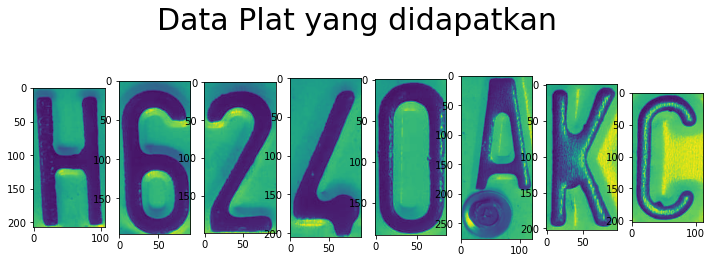

In [62]:
# tampilkan karakter yang telah terpotong
imgs=[]
for char in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    imgs.append(crop)

# buat 1 plot dan tampilkan 
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,'Data Plat yang didapatkan',fontsize=30,ha='center')
plt.show()

# Buat Model Untuk Klasifikasi 